### LSTM NN 

In this notebook, we implement LSTM Neural Network for our classification task, seeing whether it is capable of outperforming our traditional ML models (Random Forest, XGBoost, etc.).
Our motivation for testing such type of model comes from its ability to capture long-term dependencies in time series data, which is a key feature of our dataset. Additionally, a large amount of papers read on the topic where aimig at assessing whether LSTM models would perform better than traditional ML models. These papers had opposing conclusions. In order to discernate, we will conduct the experiment ourselves. 

"""

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Masking
from tensorflow.keras.callbacks import EarlyStopping

# Enable MPS acceleration for Apple Silicon
tf.config.set_visible_devices([], 'GPU')  # To ensure it uses the MPS backend
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


### Import the data and Prepare the data

In [3]:
from re import X
import pandas as pd
import numpy as np

# load my datasets
df_train_temp = pd.read_csv('Dataset/Final_train__wo_dataset.csv')
df_train_temp.head()
print(df_train_temp.shape)


(91589, 71)


In [4]:
# Check for missing values in the entire dataset
missing_values = df_train_temp.isnull().sum()

# Display columns with missing values
missing_values = missing_values[missing_values > 0]

print("Columns with missing values and their counts:")
print(missing_values)

Columns with missing values and their counts:
PC1     18318
PC2     18318
PC3     18318
PC4     18318
PC5     18318
        ...  
PC64    18318
PC65    18318
PC66    18318
PC67    18318
PC68    18318
Length: 68, dtype: int64


I DO NOT KNOW WHY A LOT OF COLUMNS HAVE MISSING VALUES IN THE DATASET. THERE SHOULD NOT BE ANY MISSING VALUES FOR THE Patinet_nmbr and Encounter_ids...


In [1]:
# THIS CODE IS JUST TO TEST THE MODEL, WAITING FOR VIDUR
import numpy as np

# Add a new column "TOREMOVE" with random values 0, 1, or 2
df_train_temp['TOREMOVE'] = np.random.choice([0, 1, 2], size=len(df_train_temp))

print(df_train_temp.shape)
df_train_temp.head()


NameError: name 'df_train_temp' is not defined

In [22]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Assuming 'df_train_temp' is your training dataset
# Sort the data by Patient_ID and Timestamp
df_train_temp = df_train_temp.sort_values(by=['patient_nbr', 'timestep']).reset_index(drop=True)

# Identify temporal and feature columns
temporal_columns = ['patient_nbr', 'timestep']  # Adjust if necessary
target_column = 'TOREMOVE'  # Replace with the actual target column name
feature_columns = df_train_temp.columns.difference(temporal_columns + [target_column])

# Initialize lists for sequences
X = []  # Input sequences
Y = []  # Targets (readmission status)

# Group by Patient_ID and process each patient's data
grouped = df_train_temp.groupby('patient_nbr')

for _, group in grouped:
    features = group[feature_columns].values  # Extract feature values for the group
    targets = group[target_column].values     # Extract target values for the group
    num_timesteps = len(features)
    
    # Create sequences with varying lengths
    for i in range(num_timesteps - 1):  # Leave the last row for Y
        X.append(features[:i+1])  # Sequence up to the current timestep
        Y.append(targets[i+1])    # The target for the next timestep

# Pad sequences to the same length for LSTM input
max_sequence_length = max(len(seq) for seq in X)  # Determine the maximum sequence length
X_padded = pad_sequences(X, maxlen=max_sequence_length, dtype='float32', padding='post')

# Convert Y to numpy array
Y = np.array(Y)

# Verify target values are as expected (0, 1, 2)
unique_targets = np.unique(Y)
if not set(unique_targets).issubset({0, 1, 2}):
    raise ValueError(f"Target column contains invalid values: {unique_targets}. Expected values: 0, 1, 2.")

# Display shapes
print("Shape of X (input sequences):", X_padded.shape)
print("Shape of Y (targets):", Y.shape)
print("Unique values in Y (targets):", unique_targets)

Shape of X (input sequences): (25657, 38, 69)
Shape of Y (targets): (25657,)
Unique values in Y (targets): [0 1 2]


In [23]:
# Example: Inspect sequences for a specific patient
patient_id = df_train_temp['patient_nbr'].iloc[0]  # Take the first patient
group = df_train_temp[df_train_temp['patient_nbr'] == patient_id]

# Check the sequences created for this patient
print(group[feature_columns])
print(group[target_column])

   PC1  PC10  PC11  PC12  PC13  PC14  PC15  PC16  PC17  PC18  ...  PC63  PC64  \
0  NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   NaN   

   PC65  PC66  PC67  PC68  PC7  PC8  PC9  encounter_id  
0   NaN   NaN   NaN   NaN  NaN  NaN  NaN      24437208  

[1 rows x 69 columns]
0    0
Name: TOREMOVE, dtype: int64


In [6]:
from sklearn.model_selection import train_test_split

# X_test and T_test are in reality the validation set
X_train, X_test, Y_train, Y_test = train_test_split(X_padded, Y, test_size=0.15, random_state=42)

print(f"Training set shape: {X_train.shape}, {Y_train.shape}")
print(f"Testing set shape: {X_test.shape}, {Y_test.shape}")

Training set shape: (20525, 38, 69), (20525,)
Testing set shape: (5132, 38, 69), (5132,)


In [7]:
from tensorflow.keras.utils import to_categorical

# One-hot encode the target labels 0,1,2 (there was no need to label encode the strings values of the classes)
Y_train_encoded = to_categorical(Y_train, num_classes=3)
Y_test_encoded = to_categorical(Y_test, num_classes=3)

print("Shape of Y_train_encoded:", Y_train_encoded.shape)
print("Shape of Y_test_encoded:", Y_test_encoded.shape)

Shape of Y_train_encoded: (20525, 3)
Shape of Y_test_encoded: (5132, 3)


In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Define the LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
model.add(Dropout(0.2))  # Dropout to reduce overfitting
model.add(Dense(50, activation='relu'))
model.add(Dense(3, activation='softmax'))  # 3 classes (0, 1, 2)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                24000     
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense (Dense)               (None, 50)                2550      
                                                                 
 dense_1 (Dense)             (None, 3)                 153       
                                                                 
Total params: 26703 (104.31 KB)
Trainable params: 26703 (104.31 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [9]:
history = model.fit(X_train, Y_train_encoded, 
                    validation_data=(X_test, Y_test_encoded), 
                    epochs=1000, 
                    batch_size=32, 
                    verbose=1)

Epoch 1/20
642/642 [==============================] - 5s 6ms/step - loss: nan - accuracy: 0.3333 - val_loss: nan - val_accuracy: 0.3350
Epoch 2/20
642/642 [==============================] - 3s 5ms/step - loss: nan - accuracy: 0.3331 - val_loss: nan - val_accuracy: 0.3350
Epoch 3/20
642/642 [==============================] - 4s 6ms/step - loss: nan - accuracy: 0.3331 - val_loss: nan - val_accuracy: 0.3350
Epoch 4/20
642/642 [==============================] - 4s 5ms/step - loss: nan - accuracy: 0.3331 - val_loss: nan - val_accuracy: 0.3350
Epoch 5/20
642/642 [==============================] - 3s 5ms/step - loss: nan - accuracy: 0.3331 - val_loss: nan - val_accuracy: 0.3350
Epoch 6/20
642/642 [==============================] - 4s 6ms/step - loss: nan - accuracy: 0.3331 - val_loss: nan - val_accuracy: 0.3350
Epoch 7/20
642/642 [==============================] - 4s 6ms/step - loss: nan - accuracy: 0.3331 - val_loss: nan - val_accuracy: 0.3350
Epoch 8/20
642/642 [============================

In [10]:
loss, accuracy = model.evaluate(X_test, Y_test_encoded, verbose=1)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

161/161 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.3350
Test Loss: nan
Test Accuracy: 0.3349571228027344


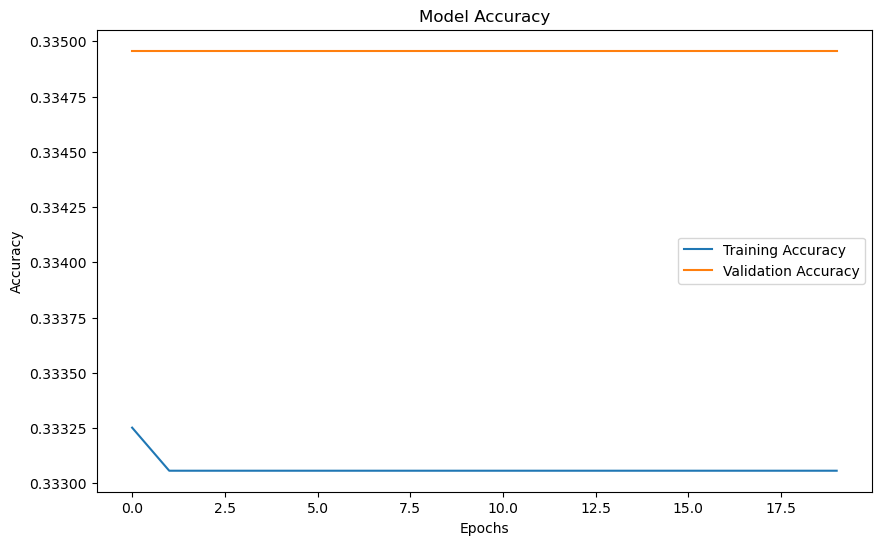

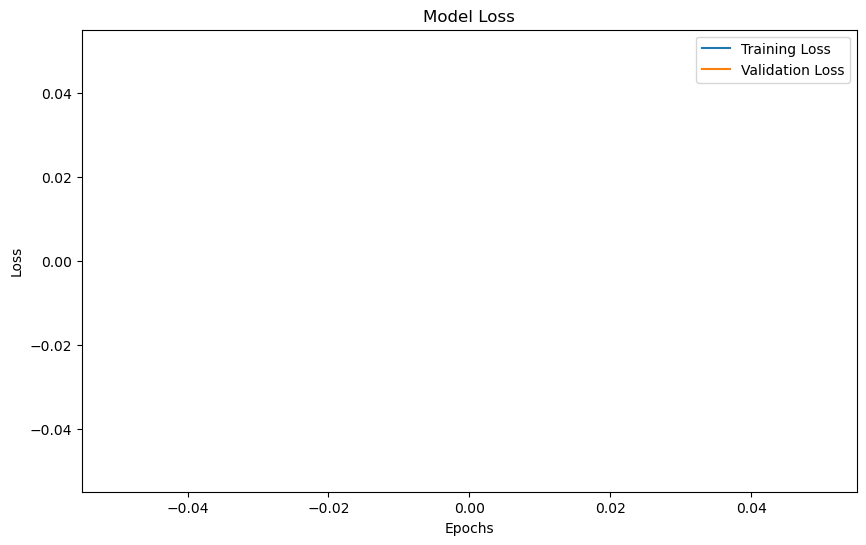

In [11]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [14]:
Y_pred = model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred, axis=1)  # Convert probabilities to class labels

print("Predicted Classes:", Y_pred_classes[:10])
print("True Classes:", Y_test[:10])

from sklearn.metrics import classification_report, confusion_matrix

print("Classification Report:")
print(classification_report(Y_test, Y_pred_classes))

print("Confusion Matrix:")
print(confusion_matrix(Y_test, Y_pred_classes))

161/161 [==============================] - 0s 2ms/step
Predicted Classes: [0 0 0 0 0 0 0 0 0 0]
True Classes: [0 1 0 1 0 0 2 0 1 1]
Classification Report:
              precision    recall  f1-score   support

           0       0.33      1.00      0.50      1719
           1       0.00      0.00      0.00      1748
           2       0.00      0.00      0.00      1665

    accuracy                           0.33      5132
   macro avg       0.11      0.33      0.17      5132
weighted avg       0.11      0.33      0.17      5132

Confusion Matrix:
[[1719    0    0]
 [1748    0    0]
 [1665    0    0]]


/Users/hindy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/hindy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/hindy/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1. Baseline LSTM model


In [ ]:
# # Define LSTM model
# model = Sequential([
#     Masking(mask_value=-1, input_shape=(X.shape[1], X.shape[2])),  # Handle padded/missing values
#     LSTM(128, return_sequences=False),
#     Dropout(0.3),
#     Dense(64, activation='relu'),
#     Dropout(0.3),
#     Dense(y.shape[1], activation='softmax')  # Output layer for multi-class classification
# ])

# # Compile the model
# model.compile(
#     optimizer='adam',
#     loss='categorical_crossentropy',
#     metrics=['accuracy']
# )

# model.summary()

Training

In [ ]:
# Split the data into training and validation sets
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Define early stopping
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=5, 
    restore_best_weights=True
)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=128,
    callbacks=[early_stopping]
)

Evaluation



In [ ]:
# Evaluate on validation set
val_loss, val_accuracy = model.evaluate(X_val, y_val)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

In [ ]:
# Save the model
model.save('lstm_readmission_model.h5')

# Load the model
from tensorflow.keras.models import load_model
loaded_model = load_model('lstm_readmission_model.h5')

2. Stacked Bidirectional LSTMs with Recurrent Dropout and L2 Regularization

This model uses:
	•	Bidirectional LSTM layers to capture both forward and backward temporal dependencies.
	•	Stacked LSTMs to increase the model’s capacity.
	•	Recurrent dropout to prevent overfitting.
	•	L2 regularization for dense layers to improve generalization.

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Masking, Bidirectional, LSTM, Dropout, Dense
from tensorflow.keras.regularizers import l2

# Model definition
model1 = Sequential([
    Masking(mask_value=-1, input_shape=(X.shape[1], X.shape[2])),
    Bidirectional(LSTM(128, return_sequences=True, recurrent_dropout=0.2)),  # First LSTM layer
    Bidirectional(LSTM(64, return_sequences=False, recurrent_dropout=0.2)), # Second LSTM layer
    Dropout(0.3),  # Dropout after LSTM
    Dense(64, activation='relu', kernel_regularizer=l2(0.01)),  # L2 regularization
    Dropout(0.3),  # Additional dropout for regularization
    Dense(y.shape[1], activation='softmax', kernel_regularizer=l2(0.01))  # Output layer
])

# Compile the model
model1.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# View summary
model1.summary()

SyntaxError: invalid syntax (1954762761.py, line 1)

3. LSTM with Attention Mechanism and Learning Rate Scheduler

This model uses:
	•	Attention mechanism to focus on the most important timesteps in the sequence.
	•	Learning rate scheduler to dynamically adjust the learning rate during training for better convergence.
	•	A single LSTM layer with recurrent dropout and dense layers for classification.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Masking, LSTM, Dropout, Dense, Attention, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Define the model with Attention
input_layer = Input(shape=(X.shape[1], X.shape[2]))
masked_input = Masking(mask_value=-1)(input_layer)
lstm_output = LSTM(128, return_sequences=True, recurrent_dropout=0.2)(masked_input)
attention_output = Attention()([lstm_output, lstm_output])  # Self-attention
flatten = Dense(64, activation='relu')(attention_output)
dropout = Dropout(0.3)(flatten)
output_layer = Dense(y.shape[1], activation='softmax')(dropout)

model2 = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model2.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Learning rate scheduler
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5)

# View summary
model2.summary()